In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_data.csv')

# Convert 'Date' to datetime and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)  # Drop the original 'Date' column

# Encode categorical variables
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])

df.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,CPI,Unemployment,Type,Size,week,month,year,Year,Month,Day
0,0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,0,151315,5,2,2010,2010,2,5
1,1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,0,151315,5,2,2010,2010,2,5
2,2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,0,151315,5,2,2010,2010,2,5
3,3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,0,151315,5,2,2010,2010,2,5
4,4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,0,151315,5,2,2010,2010,2,5


In [3]:
# Dropping duplicate columns
df.drop(['year', 'month', 'week'], axis=1, inplace=True)

In [4]:
df.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Day
0,0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,2,5
1,1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,2,5
2,2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,2,5
3,3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,2,5
4,4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,2010,2,5


In [5]:
# Creating interaction terms
df['Store_Dept'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)
df['Type_Size'] = df['Type'].astype(str) + '_' + df['Size'].astype(str)

# Creating rolling averages and lag features
df.sort_values(by=['Store', 'Dept', 'Year', 'Month', 'Day'], inplace=True)

# Rolling averages for 4 weeks and 12 weeks
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())
df['Rolling_Mean_12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=12).mean())

# Lag features for the previous week
df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

# Drop the first 12 rows for each group since they won't have complete rolling features
df = df.groupby(['Store', 'Dept']).apply(lambda x: x.iloc[12:]).reset_index(drop=True)

# Handling missing values in new columns
df.fillna(method='ffill', inplace=True)

# Encoding new categorical features
label_encoder = LabelEncoder()
df['Store_Dept'] = label_encoder.fit_transform(df['Store_Dept'])
df['Type_Size'] = label_encoder.fit_transform(df['Type_Size'])

In [6]:
df.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Year,Month,Day,Store_Dept,Type_Size,Rolling_Mean_4,Rolling_Mean_12,Lag_1
0,870,1,1,16555.11,False,67.41,2.780,0.0,0.0,0.0,...,0,151315,2010,4,30,728,0,23314.5825,29066.0400,16145.35
1,941,1,1,17413.94,False,72.55,2.835,0.0,0.0,0.0,...,0,151315,2010,5,7,728,0,16927.8400,26680.5775,16555.11
2,1013,1,1,18926.74,False,74.78,2.854,0.0,0.0,0.0,...,0,151315,2010,5,14,728,0,17260.2850,24791.5100,17413.94
3,1085,1,1,14773.04,False,76.44,2.826,0.0,0.0,0.0,...,0,151315,2010,5,21,728,0,16917.2075,24405.6350,18926.74
4,1155,1,1,15580.43,False,80.44,2.759,0.0,0.0,0.0,...,0,151315,2010,5,28,728,0,16673.5375,23885.0125,14773.04


In [7]:
# Redefining FEATURES after adding new features
FEATURES = [i for i in df.columns if i != 'Weekly_Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df['Weekly_Sales'], test_size=0.2, random_state=130)

In [8]:
# Training the XGBoost model
xgb_model = XGBRegressor(n_estimators=2000, early_stopping_rounds=50, learning_rate=0.5)
xgb_model.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:12141.62053	validation_1-rmse:12619.84374
[100]	validation_0-rmse:1988.78899	validation_1-rmse:3630.02175
[200]	validation_0-rmse:1681.27048	validation_1-rmse:3532.98238
[300]	validation_0-rmse:1503.59264	validation_1-rmse:3503.34911
[400]	validation_0-rmse:1363.43134	validation_1-rmse:3480.76123
[500]	validation_0-rmse:1256.86924	validation_1-rmse:3474.03353
[600]	validation_0-rmse:1178.59410	validation_1-rmse:3466.11169
[700]	validation_0-rmse:1108.23156	validation_1-rmse:3462.30224
[800]	validation_0-rmse:1044.09565	validation_1-rmse:3459.30513
[857]	validation_0-rmse:1013.67098	validation_1-rmse:3459.56896


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Predictions
predictions_xgb = xgb_model.predict(X_test)

In [10]:
# Calculate the mean squared error and R^2 Score for XGBoost model
mse_xgb = mean_squared_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)


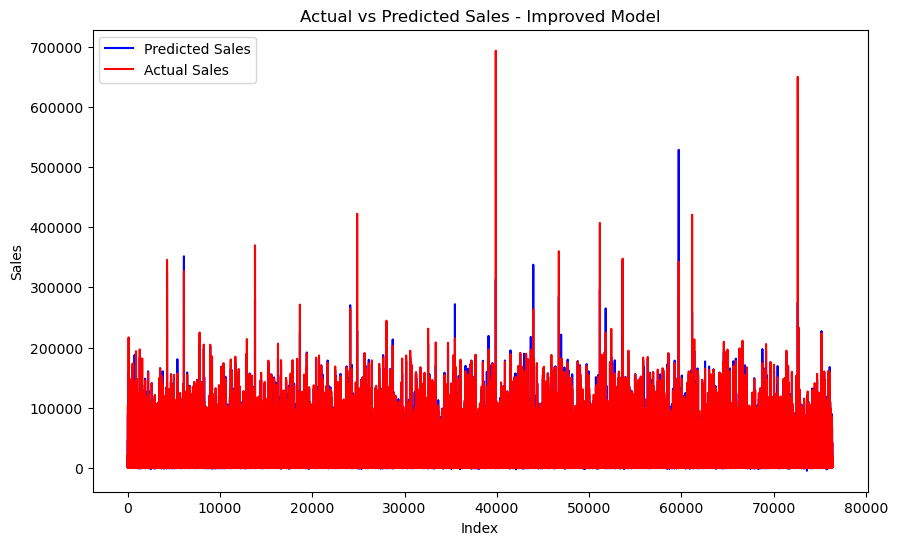

In [11]:
# Visualization using seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(predictions_xgb)), y=predictions_xgb, color="blue", label="Predicted Sales")
sns.lineplot(x=np.arange(len(y_test)), y=y_test.values, color="red", label="Actual Sales")
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales - Improved Model')
plt.legend()
plt.show()


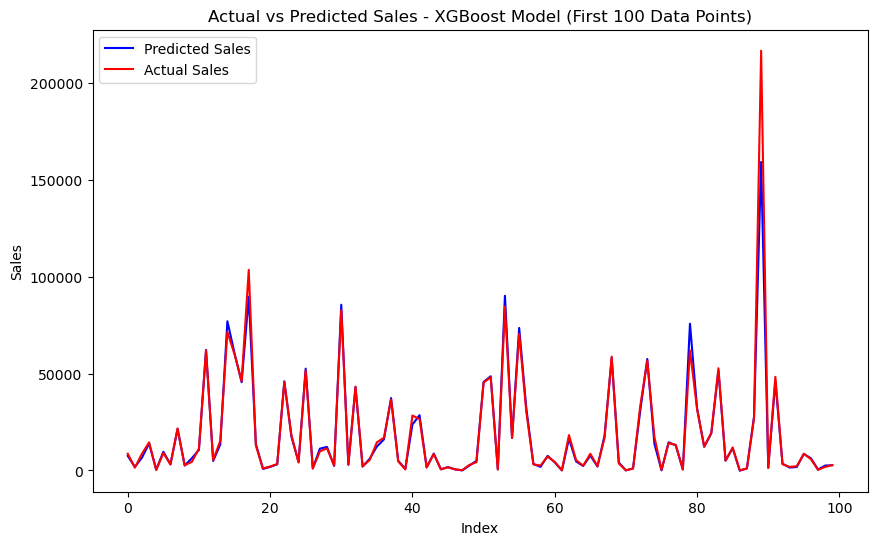

In [12]:
# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(100), y=predictions_xgb[:100], color="blue", label="Predicted Sales")
sns.lineplot(x=np.arange(100), y=y_test.values[:100], color="red", label="Actual Sales")
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales - XGBoost Model (First 100 Data Points)')
plt.legend()
plt.show()

In [13]:
print(f"Mean Squared Error: {mse_xgb:.2f}")
print(f"R-squared Score: {r2_xgb:.4f}")

Mean Squared Error: 11962011.93
R-squared Score: 0.9776


In [14]:
sales_comparison = pd.DataFrame({
    'Actual Sales': y_test[:10].values, 
    'Predicted Sales': predictions_xgb[:10]  
})

# Display the DataFrame
print(sales_comparison)

   Actual Sales  Predicted Sales
0       8617.40      7505.801758
1       1387.45      1834.609497
2       8670.00      6616.146484
3      14511.07     13927.292969
4        204.86       388.957367
5       9035.57      9645.395508
6       3063.83      3170.278320
7      21737.09     21380.898438
8       2696.82      2516.082275
9       4372.01      6294.033203


In [17]:
r2 = 0.9776 

# Converting R-squared score to a percentage
r2_percentage = r2 * 100

# Printing the accuracy as a percentage
print("Accuracy: {:.2f}%".format(r2_percentage))


Accuracy: 97.76%
